In [1]:
import h5py
import numpy as np
import random
import os
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
def custom_mapping(x):
    # Map FreeSurfer label values to kseg tissue label values
    mapping = {
        0: 0,
        2: 3,
        3: 2,
        4: 1,
        5: 1,
        7: 6,
        8: 6,
        10: 4,
        11: 4,
        12: 4,
        13: 4,
        14: 1,
        15: 1,
        16: 5,
        17: 4,
        18: 4,
        24: 1,
        26: 4,
        28: 4,
        30: 1,
        41: 3,
        42: 2,
        43: 1,
        44: 1,
        46: 6,
        47: 6,
        49: 4,
        50: 4,
        51: 4,
        52: 4,
        53: 4,
        54: 4,
        58: 4,
        60: 4,
        62: 1,
        72: 1,
        78: 3,
        79: 3,
        81: 4,
        82: 4,
        85: 5,
    }
    # This is used to prevent replacing replaced values
    replaced_mask = np.zeros_like(x, dtype=bool)

    for original, new in mapping.items():
        mask = (x == original) & (~replaced_mask)
        x[mask] = new
        replaced_mask[mask] = True
    return x


In [3]:
files = os.listdir('./OASIS/')
random.shuffle(files)
print(files)

['OAS1_0144_MR1', 'OAS1_0181_MR1', 'OAS1_0303_MR1', 'OAS1_0372_MR1', 'OAS1_0344_MR1', 'OAS1_0411_MR1', 'OAS1_0377_MR1', 'OAS1_0023_MR1', 'OAS1_0400_MR1', 'OAS1_0035_MR1', 'OAS1_0096_MR1', 'OAS1_0330_MR1', 'OAS1_0239_MR1', 'OAS1_0426_MR1', 'OAS1_0052_MR1', 'OAS1_0432_MR1', 'OAS1_0074_MR1', 'OAS1_0212_MR1', 'OAS1_0374_MR1', 'OAS1_0146_MR1', 'OAS1_0091_MR1', 'OAS1_0183_MR1', 'OAS1_0177_MR1', 'OAS1_0416_MR1', 'OAS1_0042_MR1', 'OAS1_0166_MR1', 'OAS1_0346_MR1', 'OAS1_0054_MR1', 'OAS1_0299_MR1', 'OAS1_0433_MR1', 'OAS1_0294_MR1', 'OAS1_0190_MR1', 'OAS1_0033_MR1', 'OAS1_0090_MR1', 'OAS1_0341_MR1', 'OAS1_0188_MR1', 'OAS1_0269_MR1', 'OAS1_0070_MR1', 'OAS1_0261_MR1', 'OAS1_0227_MR1', 'OAS1_0401_MR1', 'OAS1_0112_MR1', 'OAS1_0189_MR1', 'OAS1_0438_MR1', 'OAS1_0105_MR1', 'OAS1_0340_MR1', 'OAS1_0208_MR1', 'OAS1_0421_MR1', 'OAS1_0243_MR1', 'OAS1_0027_MR1', 'OAS1_0331_MR1', 'OAS1_0010_MR1', 'OAS1_0170_MR1', 'OAS1_0348_MR1', 'OAS1_0371_MR1', 'OAS1_0191_MR1', 'OAS1_0295_MR1', 'OAS1_0272_MR1', 'OAS1_0200_MR

In [4]:
# Split the list in train and test with ratio 0.8
train_list = files[:int(len(files) * 0.8)]
test_list = files[int(len(files) * 0.8):]

In [5]:
# Create convert train files
for train_file in train_list:
    nii_img  = nib.load(f'./OASIS/{train_file}/mri/brainmask.nii.gz')
    img = nii_img.get_fdata()
    nii_label = nib.load(f'./OASIS/{train_file}/mri/aseg.nii.gz')
    label = nii_label.get_fdata()

    # Iterate over the axial dimension and save each slice separately
    for i in range(img.shape[1]):
        if i < 50:
             continue
        if i > 205:
             break
        # Get the slice along the second dimension
        slice_img = img[:, i, :]

        # Normalize slice between 0 and 1
        min_val = np.min(slice_img)
        max_val = np.max(slice_img)
        if max_val == min_val:
            # Avoid division by 0
            normalized_slice_img = np.zeros_like(slice_img, dtype=np.float32)
        else:
            normalized_slice_img = ((slice_img - min_val) / (max_val - min_val)).astype(np.float32)

        slice_label = custom_mapping(label[:, i, :]).astype(np.float32)
        np.savez(f'./Synapse/train_npz/{train_file}_slice{i:03}.npz', image=normalized_slice_img, label=slice_label)

        # Write file name into txt file
        with open('../lists/lists_Synapse/train.txt', 'a+') as file:
            file.write(f'{train_file}_slice{i:03}' + '\n')

for test_file in test_list:
    nii_img  = nib.load(f'./OASIS/{test_file}/mri/brainmask.nii.gz')
    img = nii_img.get_fdata()
    nii_label = nib.load(f'./OASIS/{test_file}/mri/aseg.nii.gz')
    label = custom_mapping(nii_label.get_fdata()).astype(np.float32)

    # Normalize the arrays between 0 and 1
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val == min_val:
        # Avoid division by 0
        normalized_img = np.zeros_like(img, dtype=np.float32)
    else:
        normalized_img = ((img - min_val) / (max_val - min_val)).astype(np.float32)

    # Create the h5 file
    with h5py.File(f'./Synapse/test_vol_h5/{test_file}.npy.h5', 'w') as file:
        file.create_dataset('image', data=normalized_img)
        file.create_dataset('label', data=label)

    # Write file name into txt file
    with open('../lists/lists_Synapse/test_vol.txt', 'a+') as file:
            file.write(f'{test_file}' + '\n')


### Find differences between OASIS and Synapse data

In [2]:
import numpy as np

In [4]:
og_case = np.load('OG_Synapse/train_npz/case0005_slice080.npz')
og_case_img = og_case['image']
og_case_label = og_case['label']

new_case = np.load('Synapse/train_npz/OAS1_0289_MR1_slice128.npz')
new_case_img = new_case['image']
new_case_label = new_case['label']

In [5]:
print(f'OG img: {og_case_img.shape}\t {og_case_img.dtype}\t {np.min(og_case_img)} ... {np.max(og_case_img)}')
print(f'OG label: {og_case_label.shape}\t {og_case_label.dtype}\t {np.min(og_case_label)} ... {np.max(og_case_label)}')
print(f'New img: {new_case_img.shape}\t {new_case_img.dtype}\t {np.min(new_case_img)} ... {np.max(new_case_img)}')
print(f'New label: {new_case_label.shape}\t {new_case_label.dtype}\t {np.min(new_case_label)} ... {np.max(new_case_label)}')

OG img: (512, 512)	 float32	 0.0 ... 1.0
OG label: (512, 512)	 float32	 0.0 ... 8.0
New img: (256, 256)	 float32	 0.0 ... 1.0
New label: (256, 256)	 float32	 0.0 ... 6.0


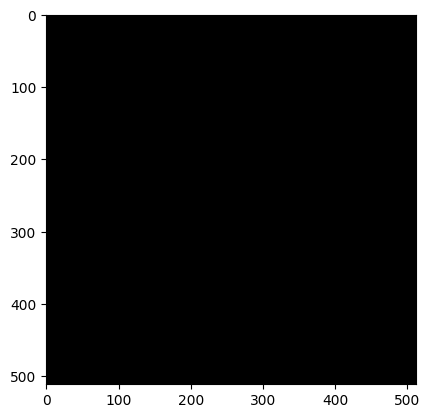

In [28]:
plt.imshow(og_case_label, cmap='gray')

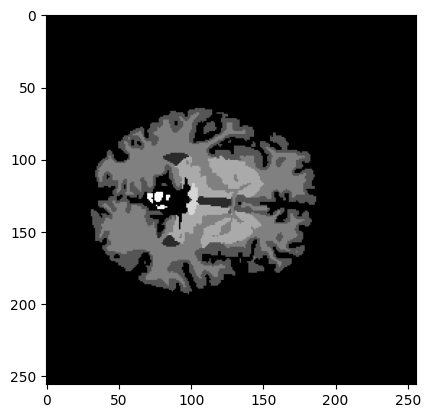

In [29]:
plt.imshow(new_case_label, cmap='gray')

In [11]:
x = custom_mapping(new_case_label)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


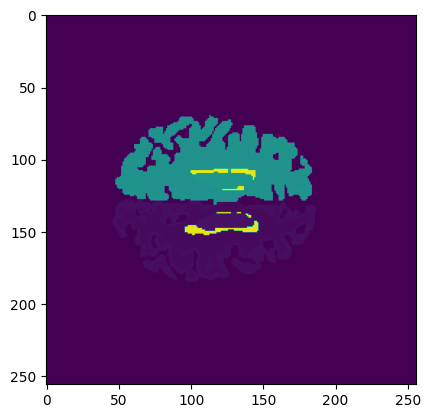

In [8]:
plt.imshow(x)

In [9]:
# Get unique elements and their counts
unique_values, counts = np.unique(x, return_counts=True)

# Print occurrences of each value
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Occurrences: {count}")

Value: 0.0, Occurrences: 54844
Value: 0.023529411764705882, Occurrences: 2400
Value: 0.03529411764705882, Occurrences: 2272
Value: 0.047058823529411764, Occurrences: 362
Value: 0.4823529411764706, Occurrences: 2628
Value: 0.49411764705882355, Occurrences: 2337
Value: 0.5058823529411764, Occurrences: 345
Value: 0.5882352941176471, Occurrences: 4
Value: 0.9176470588235294, Occurrences: 188
Value: 0.9294117647058824, Occurrences: 146
Value: 0.9529411764705882, Occurrences: 10


In [16]:
nii_img  = nib.load(f'./OASIS/OAS1_0001_MR1/mri/aseg.nii.gz')
img = nii_img.get_fdata()

In [18]:
# Get unique elements and their counts
unique_values, counts = np.unique(img, return_counts=True)

# Print occurrences of each value
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Occurrences: {count}")

Value: 0.0, Occurrences: 15853876
Value: 2.0, Occurrences: 152222
Value: 3.0, Occurrences: 184844
Value: 4.0, Occurrences: 27742
Value: 5.0, Occurrences: 1570
Value: 7.0, Occurrences: 11943
Value: 8.0, Occurrences: 47298
Value: 10.0, Occurrences: 5330
Value: 11.0, Occurrences: 3625
Value: 12.0, Occurrences: 4352
Value: 13.0, Occurrences: 1319
Value: 14.0, Occurrences: 2822
Value: 15.0, Occurrences: 2492
Value: 16.0, Occurrences: 17244
Value: 17.0, Occurrences: 3528
Value: 18.0, Occurrences: 1239
Value: 24.0, Occurrences: 1284
Value: 26.0, Occurrences: 524
Value: 28.0, Occurrences: 3575
Value: 30.0, Occurrences: 75
Value: 41.0, Occurrences: 152384
Value: 42.0, Occurrences: 183414
Value: 43.0, Occurrences: 23019
Value: 44.0, Occurrences: 1428
Value: 46.0, Occurrences: 11475
Value: 47.0, Occurrences: 47713
Value: 49.0, Occurrences: 5539
Value: 50.0, Occurrences: 3471
Value: 51.0, Occurrences: 4122
Value: 52.0, Occurrences: 1111
Value: 53.0, Occurrences: 3919
Value: 54.0, Occurrences: 1334

### Find the reason for value 255 in label

In [2]:
import numpy as np
import os

In [5]:
# Directory containing npz files
directory = "./Synapse/train_npz"

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".npz"):
        file_path = os.path.join(directory, filename)
        # Load data from npz file
        data = np.load(file_path)
        unique_values = np.unique(data['label'])
        # Check if unique values are [0, 1, 2, 3, 4, 5, 6]
        if np.any(unique_values > 6):
            print(f"File: {filename}, Unique Values: {unique_values[unique_values > 6]}")

File: OAS1_0021_MR1_slice147.npz, Unique Values: [255.]
File: OAS1_0122_MR1_slice153.npz, Unique Values: [29.]
File: OAS1_0326_MR1_slice143.npz, Unique Values: [29.]
File: OAS1_0453_MR1_slice136.npz, Unique Values: [29.]
File: OAS1_0428_MR1_slice153.npz, Unique Values: [29.]
File: OAS1_0441_MR1_slice095.npz, Unique Values: [29.]
File: OAS1_0390_MR1_slice127.npz, Unique Values: [29.]
File: OAS1_0138_MR1_slice135.npz, Unique Values: [29.]
File: OAS1_0021_MR1_slice153.npz, Unique Values: [255.]
File: OAS1_0400_MR1_slice137.npz, Unique Values: [29.]
File: OAS1_0021_MR1_slice149.npz, Unique Values: [255.]
File: OAS1_0038_MR1_slice133.npz, Unique Values: [29.]
File: OAS1_0197_MR1_slice097.npz, Unique Values: [29.]
File: OAS1_0021_MR1_slice148.npz, Unique Values: [255.]
File: OAS1_0042_MR1_slice127.npz, Unique Values: [29.]
File: OAS1_0062_MR1_slice139.npz, Unique Values: [29.]
File: OAS1_0438_MR1_slice104.npz, Unique Values: [29.]
File: OAS1_0157_MR1_slice159.npz, Unique Values: [29.]


In [7]:
# left-undetermined to left white matter (29 -> 2)
# Corpus callosum part to Deep Gray Matter (255 -> 4)
file_names = ['OAS1_0021_MR1_slice147.npz', 'OAS1_0122_MR1_slice153.npz', 'OAS1_0326_MR1_slice143.npz', 'OAS1_0453_MR1_slice136.npz', 'OAS1_0428_MR1_slice153.npz', 'OAS1_0441_MR1_slice095.npz', 'OAS1_0390_MR1_slice127.npz', 'OAS1_0138_MR1_slice135.npz', 
              'OAS1_0021_MR1_slice153.npz', 'OAS1_0400_MR1_slice137.npz', 'OAS1_0021_MR1_slice149.npz', 'OAS1_0038_MR1_slice133.npz', 'OAS1_0197_MR1_slice097.npz', 'OAS1_0021_MR1_slice148.npz', 'OAS1_0042_MR1_slice127.npz', 'OAS1_0062_MR1_slice139.npz',
              'OAS1_0438_MR1_slice104.npz', 'OAS1_0157_MR1_slice159.npz']

for filename in file_names:
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and file_path.endswith(".npz"):
            # Load data from npz file
            image = np.load(file_path)['image']
            label = np.load(file_path)['label']
            # Replace values
            label[label == 29] = 2
            label[label == 255] = 4
            # Overwrite the file
            np.savez_compressed(file_path, image=image, label=label)
            print(f"Processed: {file_path}")


Processed: ./Synapse/train_npz/OAS1_0021_MR1_slice147.npz
Processed: ./Synapse/train_npz/OAS1_0122_MR1_slice153.npz
Processed: ./Synapse/train_npz/OAS1_0326_MR1_slice143.npz
Processed: ./Synapse/train_npz/OAS1_0453_MR1_slice136.npz
Processed: ./Synapse/train_npz/OAS1_0428_MR1_slice153.npz
Processed: ./Synapse/train_npz/OAS1_0441_MR1_slice095.npz
Processed: ./Synapse/train_npz/OAS1_0390_MR1_slice127.npz
Processed: ./Synapse/train_npz/OAS1_0138_MR1_slice135.npz
Processed: ./Synapse/train_npz/OAS1_0021_MR1_slice153.npz
Processed: ./Synapse/train_npz/OAS1_0400_MR1_slice137.npz
Processed: ./Synapse/train_npz/OAS1_0021_MR1_slice149.npz
Processed: ./Synapse/train_npz/OAS1_0038_MR1_slice133.npz
Processed: ./Synapse/train_npz/OAS1_0197_MR1_slice097.npz
Processed: ./Synapse/train_npz/OAS1_0021_MR1_slice148.npz
Processed: ./Synapse/train_npz/OAS1_0042_MR1_slice127.npz
Processed: ./Synapse/train_npz/OAS1_0062_MR1_slice139.npz
Processed: ./Synapse/train_npz/OAS1_0438_MR1_slice104.npz
Processed: ./S